# Testing IL
In this notebook we will compare the IL of the implemented AMM to theory.


## Simulation Setup

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
import math

# Experiments
from model import run
from model import processing
#from model.plot_utils import *
from model import plot_utils as pu
from model import init_utils



########## AGENT CONFIGURATION ##########
# key -> token name, value -> token amount owned by agent
# note that token name of 'omniABC' is used for omnipool LP shares of token 'ABC'
LP1 = {'omniR1': 500000}
LP2 = {'omniR2': 1500000}
trader = {'LRNA': 1000000, 'R1': 1000000, 'R2': 1000000}

# key -> agent_id, value -> agent dict
agent_d = {'Trader': trader, 'LP1': LP1, 'LP2': LP2}
#agent_d = {'Trader': trader, 'LP1': LP1}


########## ACTION CONFIGURATION ##########

action_dict = {
    'sell_lrna_for_r1': {'token_buy': 'R1', 'token_sell': 'LRNA', 'amount_sell': 2000, 'action_id': 'Trade', 'agent_id': 'Trader'},
    'sell_r1_for_lrna': {'token_sell': 'R1', 'token_buy': 'LRNA', 'amount_sell': 1000, 'action_id': 'Trade', 'agent_id': 'Trader'}
}

# list of (action, number of repititions of action), timesteps = sum of repititions of all actions
trade_count = 5000
action_ls = [('trade', trade_count)]

# maps action_id to action dict, with some probability to enable randomness
prob_dict = {
    'trade': {'sell_lrna_for_r1': 0.5,
              'sell_r1_for_lrna': 0.5}
}



########## CFMM INITIALIZATION ##########

# Todo: generalize
initial_values = {
    'token_list': ['HDX', 'USD', 'R1','R2'],
    'R': [1000000, 1000000, 500000, 1500000],
    'P': [1, 1, 2, 2/3],
    'fee_assets': 0,
    'fee_LRNA': 0
}
#initial_values['H'] = [initial_values['Q'] * initial_values['W'][i] for i in range(len(initial_values['token_list']))]
#initial_values['D'] = copy.deepcopy(initial_values['H'])

#amms = [balancer_amm, reweighting_amm]
#amm_types = ['Balancer', 'Reweighting']
#amms = [reweighting_amm]
#amm_types = ['Reweighting']
#labels = amm_types
initial_list = []
config_params = {
    #'amm': amm,
    'cfmm_type': "",
    'initial_values': initial_values,
    'agent_d': agent_d,
    'action_ls': action_ls,
    'prob_dict': prob_dict,
    'action_dict': action_dict,
}

config_dict, state = init_utils.get_configuration(config_params)

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (5000, 3, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 9.26s


In [2]:
rdf, agent_df = processing.postprocessing(events)


In [3]:
%matplotlib inline



In [4]:
rdf.head(20)  # Todo: delete

,R-0,R-1,R-2,R-3,Q-0,Q-1,Q-2,Q-3,S-0,S-1,...,token_list-2,token_list-3,fee_assets,fee_LRNA,n,simulation,subset,run,substep,timestep
3,1000000,1000000,501000.00,1500000,1000000,1000000,998003.99,1000000.00,1000000,1000000,...,R1,R2,0,0,4,0,0,1,3,1
6,1000000,1000000,499998.00,1500000,1000000,1000000,1000003.99,1000000.00,1000000,1000000,...,R1,R2,0,0,4,0,0,1,3,2
9,1000000,1000000,499000.01,1500000,1000000,1000000,1002003.99,1000000.00,1000000,1000000,...,R1,R2,0,0,4,0,0,1,3,3
12,1000000,1000000,498005.99,1500000,1000000,1000000,1004003.99,1000000.00,1000000,1000000,...,R1,R2,0,0,4,0,0,1,3,4
15,1000000,1000000,499005.99,1500000,1000000,1000000,1001991.98,1000000.00,1000000,1000000,...,R1,R2,0,0,4,0,0,1,3,5
18,1000000,1000000,500005.99,1500000,1000000,1000000,999988.02,1000000.00,1000000,1000000,...,R1,R2,0,0,4,0,0,1,3,6
21,1000000,1000000,501005.99,1500000,1000000,1000000,997992.06,1000000.00,1000000,1000000,...,R1,R2,0,0,4,0,0,1,3,7
24,1000000,1000000,500003.97,1500000,1000000,1000000,999992.06,1000000.00,1000000,1000000,...,R1,R2,0,0,4,0,0,1,3,8
27,1000000,1000000,499005.95,1500000,1000000,1000000,1001992.06,1000000.00,1000000,1000000,...,R1,R2,0,0,4,0,0,1,3,9
30,1000000,1000000,498011.90,1500000,1000000,1000000,1003992.06,1000000.00,1000000,1000000,...,R1,R2,0,0,4,0,0,1,3,10


In [5]:
agent_df.tail(20)  # TODO: delete

,simulation,subset,run,substep,timestep,agent_label,q,s-0,s-1,s-2,s-3,r-0,r-1,r-2,r-3,p-0,p-1,p-2,p-3
44947,0,0,1,3,4994,LP1,0.00,0,0,500000,0,0,0,0.00,0,0,0,2.00,0.00
44948,0,0,1,3,4994,LP2,0.00,0,0,0,1500000,0,0,0.00,0,0,0,0.00,0.67
44955,0,0,1,3,4995,Trader,994345.40,0,0,0,0,0,0,1002811.40,1000000,0,0,0.00,0.00
44956,0,0,1,3,4995,LP1,0.00,0,0,500000,0,0,0,0.00,0,0,0,2.00,0.00
44957,0,0,1,3,4995,LP2,0.00,0,0,0,1500000,0,0,0.00,0,0,0,0.00,0.67
44964,0,0,1,3,4996,Trader,996364.02,0,0,0,0,0,0,1001811.40,1000000,0,0,0.00,0.00
44965,0,0,1,3,4996,LP1,0.00,0,0,500000,0,0,0,0.00,0,0,0,2.00,0.00
44966,0,0,1,3,4996,LP2,0.00,0,0,0,1500000,0,0,0.00,0,0,0,0.00,0.67
44973,0,0,1,3,4997,Trader,994364.02,0,0,0,0,0,0,1002802.20,1000000,0,0,0.00,0.00
44974,0,0,1,3,4997,LP1,0.00,0,0,500000,0,0,0,0.00,0,0,0,2.00,0.00


## Analysis

[0]


ValueError: num must be 1 <= num <= 3, not 4

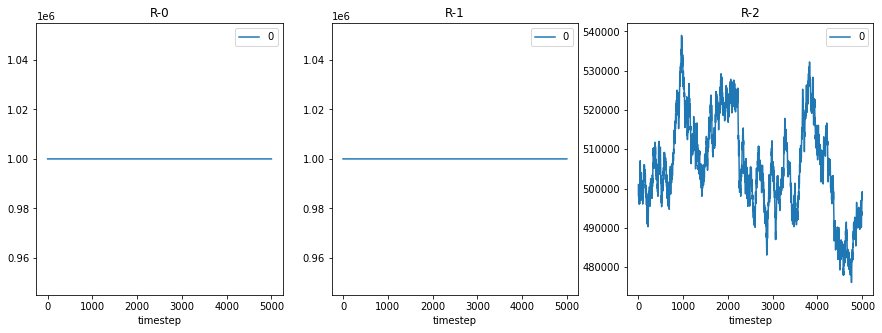

In [6]:
var_list = ['R', 'Q']
pu.plot_vars(rdf, var_list)


In [ ]:
var_list = ['r', 'q']
trader_df = agent_df[agent_df['agent_label'] == 'Trader']
pu.plot_vars(trader_df, var_list)


In [ ]:
# merge agent_df, rdf to one df on timesteps, run, etc

merged_df = pd.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])

In [ ]:
# add IL column to agent DF, where val_hold is calculated using initial holdings from agent_d
#val hold: withdraw liquidity at t=0, calculate value with prices at t
#val pool: withdraw liquidity at t, calculate value with prices at t


merged_df['P-0'] = merged_df.apply(lambda x: x['Q-0']/x['R-0'], axis=1)
merged_df['P-1'] = merged_df.apply(lambda x: x['Q-1']/x['R-1'], axis=1)
merged_df['val_pool'] = merged_df.apply(lambda x: processing.val_pool(x), axis=1)
withdraw_agent_d = processing.get_withdraw_agent_d(initial_values, agent_d)
print(withdraw_agent_d)
merged_df['val_hold'] = merged_df.apply(lambda x: processing.val_hold(x, withdraw_agent_d), axis=1)
merged_df['IL'] = merged_df.apply(lambda x: x['val_pool']/x['val_hold'] - 1, axis=1)
merged_df['pool_val'] = merged_df.apply(lambda x: processing.pool_val(x), axis=1)
#merged_df['pool_loss'] = merged_df.apply(lambda x: x['pool_val']/2000000 - 1, axis=1)

merged_df[['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','val_pool', 'val_hold','IL','pool_val', 'p-0']].tail()


# compute val hold column


# compute val pool column

# compute IL

# plot Impermanent loss
# 

In [ ]:
merged_df[merged_df['agent_label'] == 'LP2'][['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','val_pool', 'val_hold','IL','pool_val']].head(20)


In [ ]:
LP1_merged_df = merged_df[merged_df['agent_label'] == 'LP1']
LP1_merged_df[['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','val_pool', 'val_hold','IL','pool_val']].head(50)

## IL over time



In [ ]:
var_list = ['pool_val', 'val_pool', 'val_hold', 'IL']
LP1_merged_df = merged_df[merged_df['agent_label'] == 'LP1']
pu.plot_vars(LP1_merged_df, var_list)

## IL as a function of price movement

### Theory

On a price move from $p_i^Q \to k p_i^Q$, LP is entitled to $k\frac{\sqrt{k}}{k+1}$ of the *original value* of the matched pool.
$$
Val_{hold} = k p_i^Q R_i\\
Val_{pool} = \frac{\sqrt{k}k}{k+1} 2Q_i = \left(\frac{2\sqrt{k}k}{k+1}\right) p_i^Q R_i
$$

### $Val_{hold}$

In [ ]:
def val_hold_func(P, R):
    return P * R

plt.figure(figsize=(15,5))

#ax = plt.subplot(131, title='P-0/IL')
#LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])
ax = plt.subplot(131, title='P-0/val_hold')
LP1_merged_df[['val_hold','P-0']].astype(float).plot(ax=ax, y=['val_hold'], x='P-0', label=[])

#ax = plt.subplot(132, title='Theoretical')
x = LP1_merged_df['P-0'].tolist()
y = LP1_merged_df.apply(lambda x: val_hold_func(x['P-0'], LP1['omniR1']), axis=1)
ax.plot(x,y, label='Theory')

#ax = plt.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-0'].tolist()
#y = LP1_merged_df['P-0'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

### $Val_{Pool}$

In [ ]:
def val_pool_func(P, P_init, R):
    k = P/P_init
    return 2 * k * math.sqrt(k) / (k + 1) * P_init * R

plt.figure(figsize=(15,5))

#ax = plt.subplot(131, title='P-0/IL')
#LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])
ax = plt.subplot(131, title='P-0/val_pool')
LP1_merged_df[['val_pool','P-0']].astype(float).plot(ax=ax, y=['val_pool'], x='P-0', label=[])

#ax = plt.subplot(132, title='Theoretical')
x = LP1_merged_df['P-0'].tolist()
y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-0'], initial_values['P'][0], LP1['omniR1']), axis=1)
#y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-0'], initial_values['P'][0], x['R-0']), axis=1)
ax.plot(x, y, label='Theory')

#ax = plt.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-0'].tolist()
#y = LP1_merged_df['P-0'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

### Impermanent Loss

In [ ]:
def IL_func(P, P_init, R):
    return val_pool_func(P, P_init, R)/val_hold_func(P, R) - 1

plt.figure(figsize=(15,5))

#ax = plt.subplot(131, title='P-0/IL')
#LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])
ax = plt.subplot(131, title='P-0/IL')
LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])

#ax = plt.subplot(132, title='Theoretical')
x = LP1_merged_df['P-0'].tolist()
y = LP1_merged_df.apply(lambda x: IL_func(x['P-0'], initial_values['P'][0], LP1['omniR1']), axis=1)
#y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-0'], initial_values['P'][0], x['R-0']), axis=1)
ax.plot(x, y, label='Theory')

#ax = plt.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-0'].tolist()
#y = LP1_merged_df['P-0'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

In [ ]:
LP1_merged_df[['val_pool', 'val_hold', 'R-0', 's-0', 'S-0', 'B-0', 'P-0', 'p-0']].tail()